# Let's Explore Some Telco Churn Data

Data can be found here WA_Fn-UseC_-Telco-Customer-Churn.csv: https://www.kaggle.com/blastchar/telco-customer-churn/download

# What’s in the Telco Customer Churn data set?
This data set provides info to help you predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The data set includes information about:
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents



In [6]:
# %load churnlab_utils.py
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from itertools import compress
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
	
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_mat.png', bbox_inches='tight', format='png', dpi=300, pad_inches=0,transparent=True)
    plt.show()
    return
	
def pdutil_describeItemRange(df):  # Show the number of unique values in each column
    """pdutil_describeItemRange performs is similar to descrive for a DataFrame"""
    """but it displays the number of unique values in each column"""
    """argument is a dataFrame """
    """return is smaller dataFrame with the same columns as the original"""
    cols = df.columns.tolist()
    vals = pd.DataFrame ( [ len(set(df[s])) for s in df.columns.tolist()] ).T
    vals.columns = cols
    return vals

def pdutil_factorize(df):
    """pdutil_factorize performs converts every categorical column in a dataFrame to numeric values"""
    """pass in a DataFrame"""
    """return value is a similar dataFrame but with categorical values converted to numbers"""    
    return  df.apply(lambda x: pd.factorize(x)[0])

def pdutil_OneHotEncode(pdold, StaticCols, EncodeCols):
    """pdutil_OneHotEncode performs OneHotEncoding on specified columns in our dataframe"""
    """pdold is the old dataframe we are paasing in"""
    """StaticCols is a list of columns we do not wish to encode"""
    """EncodeCols is a list of columns we wish to encode"""
    """Returns a modified DataFrame with oneHotEncoded columns"""
    # make sure that we our static list is not in our encode list
    cols_OneHotEncode = sorted(list(set(EncodeCols) - set(StaticCols)))
    # create a new dataframe which represents the static columns
    pdnew = pdold[StaticCols]
    # loop thru the endcode list and OneHotEncode (using get_dummies) each column in the encode list
    # note - this will typically map a single column to several columns - one for each value contained in the original column
    for col in cols_OneHotEncode:
        new_names = []
        enc = pd.get_dummies(pdold[col])
        for subcol in  enc:
            name = col + str(subcol)
            new_names.append(name)
        enc.columns = new_names
        # concat the new OneHotEnoded dataframe to the original
        pdnew = pd.concat([pdnew, enc], axis=1)
    return pdnew


def pdutil_dbscan(df, eps_):
# Compute DBSCAN
    labels = []
    db = DBSCAN(eps=eps_, min_samples=100).fit(df)
    labels = pd.DataFrame(db.labels_ )
    #n_clusters_ = labels[0].madf()
    n_clusters_ = len(list(set(db.labels_))) - (1 if -1 in db.labels_ else 0)
    # Number of clusters in labels, ignoring noise if present.
    tdft = 'dbsPCA'
    df[tdft]=labels
    print('eps:{} Estimated number of clusters: {}'.format(eps_, n_clusters_) ) 
    return df, labels, n_clusters_

## import tensorflow as tf
import numpy as np
import pandas as pd
import math

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np

CLASS_SIZE = 2
#DATA_SIZE = 0

def load_csv(filename):
    file = pd.read_csv(filename, header=0)

    # get sample's metadata
    n_samples = int(file.columns[0])
    n_features = int(file.columns[1])

    # divide samples into explanation variables and target variable
    data = np.empty((n_samples, n_features))
    target = np.empty((n_samples,), dtype=np.int)
    for i, row in enumerate(file.itertuples()):
        target[i] = np.asarray(row[-1], dtype=np.int)
        data[i] = np.asarray(row[1:n_features+1], dtype=np.float64)
    return (data, target)

# output train data 
def get_batch_data(x_train, y_train, size=None):
    if size is None:
        size = len(x_train)
    batch_xs = x_train
    batch_ys = []

    # convert to 1-of-N vector
    for i in range(len(y_train)):
        val = np.zeros((CLASS_SIZE), dtype=np.float64)
        val[y_train[i]] = 1.0
        batch_ys.append(val)
    batch_ys = np.asarray(batch_ys)
    return batch_xs[:size], batch_ys[:size]

# output test data
def get_test_data(x_test, y_test):
    batch_ys = []

    # convert to 1-of-N vector
    for i in range(len(y_test)):
        val = np.zeros((CLASS_SIZE), dtype=np.float64)
        val[y_test[i]] = 1.0
        batch_ys.append(val)
    return x_test, np.asarray(batch_ys)

# for parameter initialize
def get_stddev(in_dim, out_dim):
    return 1.3 / math.sqrt(float(in_dim) + float(out_dim))

# DNN Model Class
class Classifier:
    def __init__(self, hidden_units=[10], n_classes=0, data_size = 0):
        self._hidden_units = hidden_units
        self._n_classes = n_classes
        self._data_size = data_size
        self._sess = tf.Session()

    # build model
    def inference(self, x):
        hidden = []

        # Input Layer
        with tf.name_scope("input"):
            weights = tf.Variable(tf.truncated_normal([self._data_size , self._hidden_units[0]], stddev=get_stddev(self._data_size, self._hidden_units[0]), seed=42), name='weights')
            biases = tf.Variable(tf.zeros([self._hidden_units[0]]), name='biases')
            input = tf.matmul(x, weights) + biases

        # Hidden Layers
        for index, num_hidden in enumerate(self._hidden_units):
            if index == len(self._hidden_units) - 1: break
            with tf.name_scope("hidden{}".format(index+1)):
                weights = tf.Variable(tf.truncated_normal([num_hidden, self._hidden_units[index+1]], seed=42, stddev=get_stddev(num_hidden, self._hidden_units[index+1])), name='weights')
                biases = tf.Variable(tf.zeros([self._hidden_units[index+1]]), name='biases')
                inputs = input if index == 0 else hidden[index-1]
                hidden.append(tf.nn.relu(tf.matmul(inputs, weights) + biases, name="hidden{}".format(index+1)))
        
        # Output Layer
        with tf.name_scope('output'):
            weights = tf.Variable(tf.truncated_normal([self._hidden_units[-1], self._n_classes], seed=42, stddev=get_stddev(self._hidden_units[-1], self._n_classes)), name='weights')
            biases = tf.Variable(tf.zeros([self._n_classes]), name='biases')
            logits = tf.nn.softmax(tf.matmul(hidden[-1], weights) + biases)

        return logits

    # loss function
    def loss(self, logits, y):        
        #return -tf.reduce_mean(y * tf.log(logits))
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

    # fitting function for train data
    def fit(self, x_train=None, y_train=None, steps=200):
        # build model
        x = tf.placeholder(tf.float32, [None, self._data_size ])
        y = tf.placeholder(tf.float32, [None, CLASS_SIZE])
        logits = self.inference(x)
        loss = self.loss(logits, y)
        train_op = tf.train.AdamOptimizer(0.003).minimize(loss)

        # save variables
        self._x = x
        self._y = y
        self._logits = logits
 
        # init parameters
        #init = tf.initialize_all_variables() 
        init = tf.global_variables_initializer()
        self._sess.run(init)

        # train
        for i in range(steps):
            batch_xs, batch_ys = get_batch_data(x_train, y_train)
            self._sess.run(train_op, feed_dict={x: batch_xs, y: batch_ys})

    # evaluation function for test data
    def evaluate(self, x_test=None, y_test=None):
        x_test, y_test = get_test_data(x_test, y_test)
        
        # build accuracy calculate step
        correct_prediction = tf.equal(tf.argmax(self._logits, 1), tf.argmax(self._y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # evaluate
        return self._sess.run([accuracy], feed_dict={self._x: x_test, self._y: y_test})

    # label prediction
    def predict(self, samples):
        predictions = tf.argmax(self._logits, 1)
        return self._sess.run(predictions, {self._x: samples})


# Choose interactive or inline plotting

In [7]:
%matplotlib notebook


# Read the Telco Customer Churn Dataset

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
# Added to support multiple environments
#!https://www.kaggle.com/blastchar/telco-customer-churn/download
churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [11]:
# In the cell below fix the code to display first few rows of the churn dataset

In [10]:
pd.set_option('display.max_columns', 70)
df

# Notice that the data in various columns might be strings, integers, floats, whatever
# We need a way to convert all these items into numbers, this is part of data prep and data cleaning


NameError: name 'df' is not defined

### How big is my data, what shape is it?

detemrine how many rows and columns of data you have using the shape attribute of your dataframe

# How much data prep do I have to do?

Lets see which columns are already numbers versus some other data type, such as string or objects

Here we see there are 18 object columsn that are NOT number types

modify the code below so that the colors list is active (uncomment the line) so the code will correctly run

In [44]:
del colors  # cell is broken, fix it
plt.ylim(0,18, 1)
#colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c'] 
pd.DataFrame(churn.dtypes,columns=['objectType']).objectType.value_counts().plot(kind='bar', color = colors )
#myhist.objectType.value_counts().plot(kind='bar')

NameError: name 'colors' is not defined

# Some Cleaning Required       :-)
In reality, on **real datasets**, this takes on the order of **80%** of datascientist time.

For this dataset, TotalCharges is an object rather than a float64. We will convert it to float64 and **force any non numeric items** to be imputed with the **mean**.

Other methods might interpolate a missing value using a linear interpolation, or use the max value, or in some cases drop these instances or dro the feature - it all depends on the data.

# Artifically force dirty the data to make a point

We will inject None, NaN, Inf into various columns to demonstrate what non-cleaned data might look like. 

This will motivate our examples of detecting and cleaning this kind of data


In [42]:
# Data was too clean - lets artifically inject some NULL data to see how to detect the,m in later steps

nullmask1 = [5, 47, 1962, 1987, 1991, 1994, 2018]
nullmask2 = [2, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]
nullmask3 = [3,13,23]
churn.loc[nullmask1, 'SeniorCitizen'] = None
churn.loc[nullmask2, 'TotalCharges'] = float('NaN')
churn.loc[nullmask3, 'MonthlyCharges'] = float('Inf')

# Determine how many NaN's, None's, Inf's exist in the data

This can be done for the entire data set or on a column by column basis

In [45]:
pd.options.mode.use_inf_as_na = True
#churn.apply(pd.Series.nunique)   # cardinality
print(churn.isnull().sum().sum())  # count Nan's in entire dataframe|
#print(churn.isnull().sum() )  # count Nan's by column


21


## Determine Where the NaN's are: Bar Chart of Frequencies

Here we use a variation of a histogram, implenmented as a bar plot, to count the frequencies of NaN's in our data set for each column.

Nan's must be delat with prior to any modelling

This is helpful to visualize - because it is a visual depiction of what is blocking you from creating models.
Its a helpful chart to bring to other teams when asking for help 

**"I can use your SME expertise here, These items are blocking me. In your opinion how should I deal with NaNs and INF, and Nones?  SHould I drop the row? replace with the mean or max or min or some other value?"**

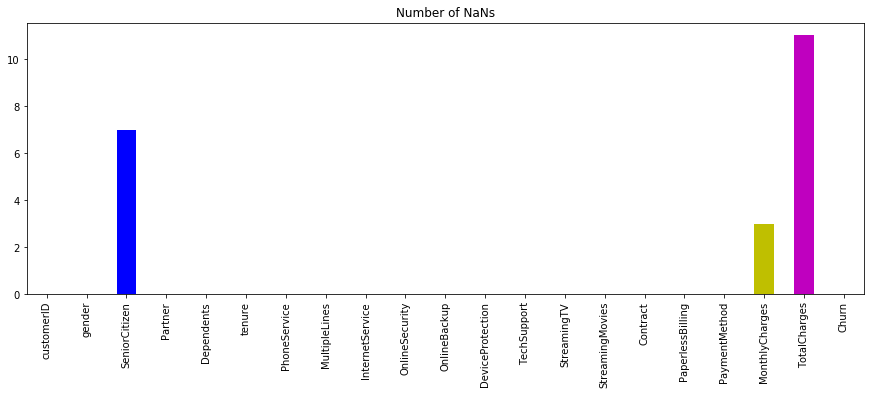

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c'] 
plt.figure(figsize=(15, 5))
churn.isnull().sum().plot(kind='bar',color = colors, title='Number of NaNs')


## Correct Nan's or Reload the dataset 

Reloading the data to undo the Nan experiment from above.

These are ways you can implement an SME's suggestion to fill NANs or INF or whatever with values

#### ??? does the code below error out ?

We are trying to fillna with a value - why does it crash - spend 1 few minutes troubleshooting online

In [46]:
#harder problem - see solutioin in stack overflow or below
churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

TypeError: must be str, not int

In [ ]:
# Here's a code fix so all Nan's and inf can be removed

# the nans and inf's from before are apparently treated as strings in an othersie numeric column and caused some errors
# stack overflow is your friend!

In [47]:
churn[['TotalCharges']] = churn[['TotalCharges']].apply(pd.to_numeric, errors='coerce') 
churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

churn[['SeniorCitizen']] = churn[['SeniorCitizen']].apply(pd.to_numeric, errors='coerce') 
churn["SeniorCitizen"].fillna(churn["SeniorCitizen"].mean(), inplace=True)

churn.MonthlyCharges.replace(np.inf, 0, inplace=True)

churn[['MonthlyCharges']] = churn[['MonthlyCharges']].apply(pd.to_numeric, errors='coerce') 
churn["MonthlyCharges"].fillna(churn["MonthlyCharges"].mean(), inplace=True)

#if(nimbix) :
#    churn = pd.read_csv('/data/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#else :
#    churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')


# DATA EXPLORATION

Describe the Range of Values in each Column
The is an important step in understanding your data. Not only should I have an understanding of the size and shape of my data, the number of rows and columns, but also how many unique values each column may take on. This is important for upcoming steps where we encode the data for consumption by a model. knowing how many possible values can influence the choice of encodig such one-hot-encoding verus binning for example. For classification purposes, the categorical values (most of the entirety of this table) have 2 to 4 possible values and might be candidates for one-hot-encoding or similar encodings.  But MonthlyCharges and TotalCharges, if manipulated at all, might benefit from binning, since this is more of a continous varibale and not categorical.

In [24]:
pdutil_describeItemRange(churn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7043,2,9,2,2,73,2,3,3,3,3,3,3,3,3,3,2,4,1585,6523,2


In [ ]:
churn.describe()

## Explore the Cardinality of the Dataset Visually

Here we explore the cardinality of the data - how many varieties of values are ther in each column.

Categorical data hopefully will have a handful of values, numeric data will likely have many attainable values.

This step is for sanity checking. Do expect a smaller number of choices for a given column to be able to acquire?

What if the categorical data has huge cardinality? For example, zip codes have huge cardinality. Some researchers recommend 

replacing zip code with a numerica value that represents a presentage - such as perentage of each zip codes contribution to sales, or percentage of of occurences of that zip code out of all zip codes

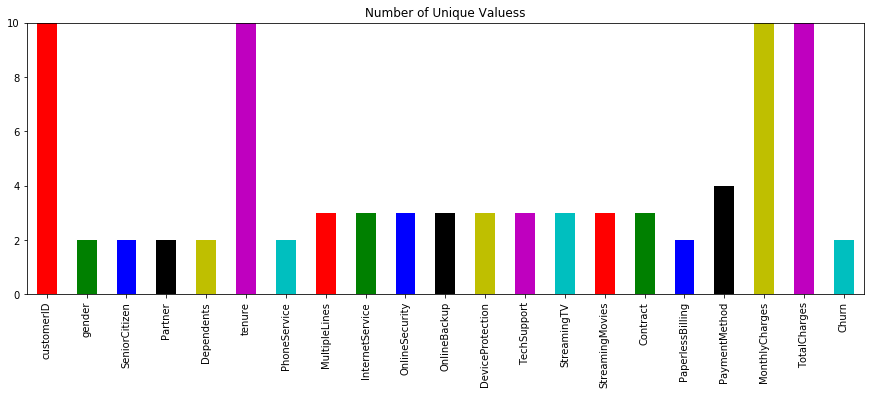

In [25]:
plt.figure(figsize=(15, 5))

churn.apply(pd.Series.nunique).plot(kind='bar', color = ['r', 'g', 'b', 'k', 'y', 'm', 'c'], title='Number of Unique Valuess', ylim=(0,10) )

## Break Dataset into Two Parts: Categorical, and Numeric

Breaking apart just to handle each group conceptually differently. More work required on categrical data

churn_cat_col will be a list indicating which are categorical
churn_num_col will be a list indicating which are numerical

In [48]:
# here are the columns which are categorical
churn_cat_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['object']]
# here are the columns which are numeric
churn_num_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['float64', 'int64']]
#create a dataframe to hold categorical data
churn_cat = churn[churn_cat_col]
#create a dataframe to hold numeric data
churn_num = churn[churn_num_col]
# display first few rows of numerical data to get a feel for them
print (churn_num.head())
# display first few rows of categorical data to get a feel for them
churn_cat.head()

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges
0            0.0       1           29.85     29.850000
1            0.0      34           56.95   1889.500000
2            0.0       2           53.85   2284.431783
3            0.0      45            0.00   1840.750000
4            0.0       2           70.70   2284.431783


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [49]:
# Compute stats on numerical data - see if you have any aha moments
churn_num.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162308,32.371149,64.732458,2284.431783
std,0.368576,24.559481,30.114889,2263.362305
min,0.000000,0.000000,0.000000,18.800000
25%,0.000000,9.000000,35.450000,403.250000
50%,0.000000,29.000000,70.350000,1405.300000
75%,0.000000,55.000000,89.850000,3780.625000
max,1.000000,72.000000,118.750000,8684.800000


# Convert Categories to Numbers

We apply the factorize function to all the categories as a first pass. We created a new dataframe here called **churn_cat_encode**

The commented out code would allow us to map back to the original form if needed

PaymentMethod for example will now have numeric values like 0, 1, 2, 3,...:

Look at PaymentMethod column - did you notice that the cardinality is something like 4?

SHould it matter when predicting from a model that PaymentMethod = 3 is a larger value than PaymentMethod 1? Or is the numerical ordering more accidental and not something a model should pay attention to?

### Is this One hot encoding yet???


In [50]:
#  pd_factorize the categorical churn columns
# after this step all categories are nubers
churn_cat_encode = pdutil_factorize(churn_cat)
churn_cat_encode.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0
2,2,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1
3,3,1,1,0,0,0,0,1,1,1,1,0,0,1,1,2,0
4,4,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1


In [51]:
# take a moment to find a pandas function to find unique value for columns
# everything is numbers now - but do the numbers makes sense?
# a column with 4 values 0,1,2,3  seems to indicates that 3 is stronger or more valueable or more heavily weights than any other tiem in the column
# should this e the case for a given column?
churn_cat_encode.nunique()


customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64

# Encode the data (OneHotEncode)
The problem with the data above is that while the data are numeric, it give arbitrary low weights to categories encoded with 0 and higher weights to others

This will probably skew our analysis. For example, PaymentMethod has values 0, 1, 2.  Do we really mean to imply that PaymentMethod=0 has no weight, but PaymentMethod=2 has twice as much weight as PaymentMethod=1?

We use OneHotEncode here to make sure each value that was used is encoded with the value 1, while the value will be 0 if that feature was not used.

**Note:** We dont want to encode categories with many unique values in it such as customerID. 

We define a funvtion to handle doing the encoding for us

Now PaymentMethod will be split into brand new columns (one for each kind of numeric value) and each cell will have either 0 or 1, kind of like a check box, indicating the feature was present or not.

We also concatenate the previous numerical columns back in to have them available for analysis after standardization.

In [52]:
# list of column name I wish to OneHotEncode
cols_OneHotEncode = ['DeviceProtection','TechSupport','OnlineBackup','MultipleLines','gender','StreamingTV','Contract','StreamingMovies','PhoneService','PaperlessBilling','OnlineSecurity','Partner','Dependents','InternetService','PaymentMethod']
# label is the column I ultimately want to predict aka Churn
label = churn_cat_encode['Churn']
# customer is the column representing the customerId
customer =  churn_cat_encode['customerID']  # going to use later
churn_encoded_numeric = pdutil_OneHotEncode (churn_cat_encode, [], cols_OneHotEncode)
# join the two kinds of data - categoricaal (oneHotEncoded) to the original Numerical data
churn_encoded_numeric = pd.concat([churn_encoded_numeric, churn_num], axis=1)  # add numeric to main df
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,InternetService2,MultipleLines0,MultipleLines1,MultipleLines2,OnlineBackup0,OnlineBackup1,OnlineBackup2,OnlineSecurity0,OnlineSecurity1,OnlineSecurity2,PaperlessBilling0,PaperlessBilling1,Partner0,Partner1,PaymentMethod0,PaymentMethod1,PaymentMethod2,PaymentMethod3,PhoneService0,PhoneService1,StreamingMovies0,StreamingMovies1,StreamingMovies2,StreamingTV0,StreamingTV1,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0.0,1,29.85,29.850000
1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0.0,34,56.95,1889.500000
2,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0.0,2,53.85,2284.431783
3,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0.0,45,0.00,1840.750000
4,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0.0,2,70.70,2284.431783


In [53]:
churn_encoded_numeric.shape

(7043, 45)

# Exploring Data: Plotting One Hot Encoded Data is Problematic

You tend to get a few huge piles of dots that dont contribute much to understanding the data

### Plotting in 3D Won't Help Here Either 

Part of what you will learn in this lab are ways to explore data that is hesitant to be explored

How can we get a feel for our customers in the data frame if this is all I have to work with?

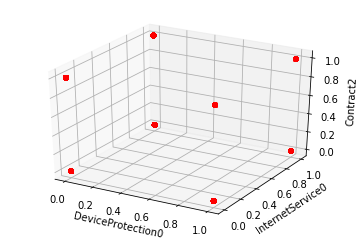

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = churn_encoded_numeric['DeviceProtection0']
y = churn_encoded_numeric['InternetService0']
z = churn_encoded_numeric['Contract2']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('DeviceProtection0')
ax.set_ylabel('InternetService0')
ax.set_zlabel('Contract2')

plt.show()

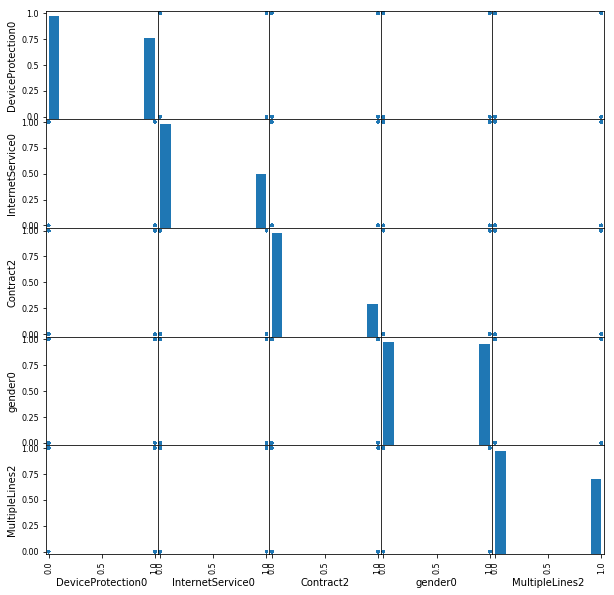

In [39]:
# even a scatter_matrix is NOT useful
%matplotlib inline
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

cols_ = ['DeviceProtection0','InternetService0','Contract2','gender0','MultipleLines2']

scatter_matrix(churn_encoded_numeric[cols_], alpha=0.4, figsize=[10,10], grid=True)
plt.show()

# Standardize the Data

We scale and center the data around the mean. The reason is to make sure that each column gets a fair vote in the upcoming pca.  Without scaling, a column such as total_charges, with large range of values with larger absolute magnitude could dominate in PCA and effectively become the defacto largest pca component.

In [55]:
# if you get this error:
# ValueError: Input contains infinity or a value too large for dtype('float64')
# then you did not clean up your nans
from sklearn import preprocessing
#scale our data to zero center it
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric)
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)

I:\Anaconda3\envs\mldl\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
I:\Anaconda3\envs\mldl\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


# Exploring Data: Categorical 

## Copy Churn Column to Encoded Dataframe
This dataframe has the same number of rows as the principal components Dataframe

They are parallel with each other

This copy step may be redundant since we copied Churn to the PCA Dataframe too, but it makes plotting more convenient

In [56]:
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)


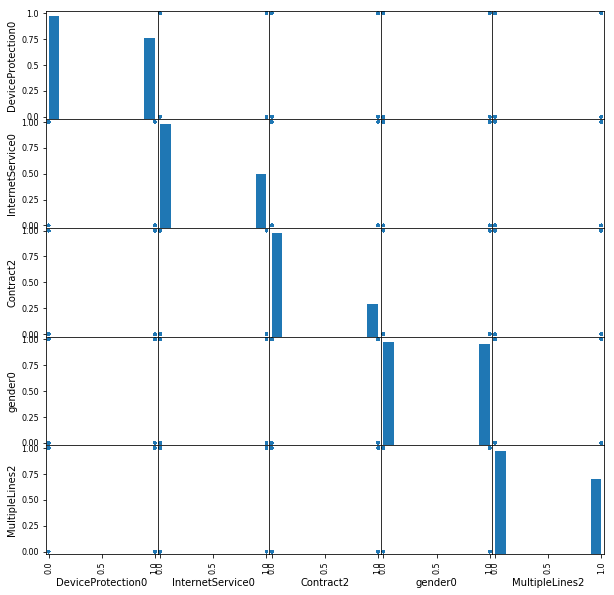

In [57]:
%matplotlib inline
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

cols_ = ['DeviceProtection0','InternetService0','Contract2','gender0','MultipleLines2']

scatter_matrix(churn_encoded_numeric[cols_], alpha=0.4, figsize=[10,10], grid=True)
plt.show()

# Exploring Data:  Correlation Plot
Plot shows which factors are correlated with which ohers and to what degree.

Here, red means highly correlated (as in correlated with Churn being bad therefor red), blue means negatively correlated, and white means no correlation.
**Notice** A customer with more contracts, more dependents, more tenure are less likley to churn in this example.

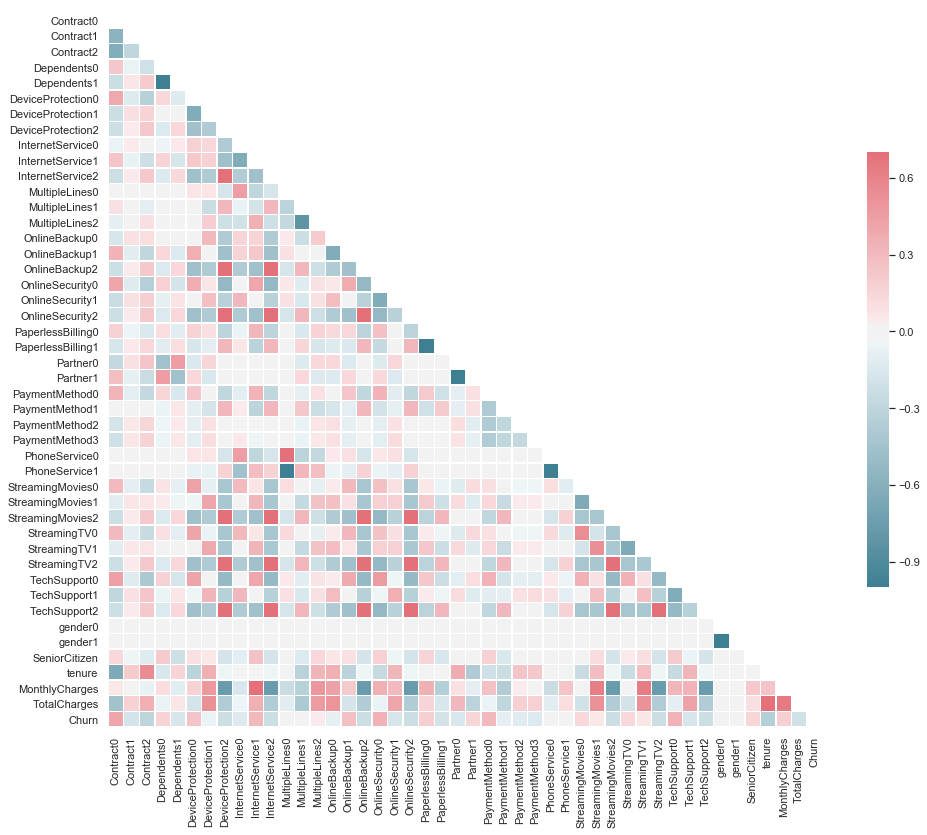

In [58]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = churn_encoded_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
churn_encoded_numeric[(churn_encoded_numeric['Contract0'] == 1)].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,InternetService2,MultipleLines0,MultipleLines1,MultipleLines2,OnlineBackup0,OnlineBackup1,OnlineBackup2,OnlineSecurity0,OnlineSecurity1,OnlineSecurity2,PaperlessBilling0,PaperlessBilling1,Partner0,Partner1,PaymentMethod0,PaymentMethod1,PaymentMethod2,PaymentMethod3,PhoneService0,PhoneService1,StreamingMovies0,StreamingMovies1,StreamingMovies2,StreamingTV0,StreamingTV1,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,3875.0,3875.0,3875.0,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000
mean,1.0,0.0,0.0,0.796387,0.203613,0.617806,0.246968,0.135226,0.315613,0.549161,0.135226,0.097032,0.520516,0.382452,0.274323,0.590452,0.135226,0.678968,0.185806,0.135226,0.667355,0.332645,0.356129,0.643871,0.477419,0.230452,0.152000,0.140129,0.097032,0.902968,0.528258,0.336516,0.135226,0.529806,0.334968,0.135226,0.691613,0.173161,0.135226,0.496774,0.503226,0.208426,18.036645,66.371729,1372.036293,0.427097
std,0.0,0.0,0.0,0.402736,0.402736,0.485986,0.431303,0.342009,0.464819,0.497642,0.342009,0.296040,0.499643,0.486049,0.446230,0.491814,0.342009,0.466933,0.389001,0.342009,0.471221,0.471221,0.478916,0.478916,0.499554,0.421176,0.359067,0.347166,0.296040,0.296040,0.499265,0.472579,0.342009,0.499175,0.472040,0.342009,0.461887,0.378435,0.342009,0.500054,0.500054,0.406062,17.689054,26.941045,1612.737969,0.494720
min,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.850000,0.000000
25%,1.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,45.825000,161.000000,0.000000
50%,1.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,73.200000,688.000000,0.000000
75%,1.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,88.850000,2077.075000,1.000000
max,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1

In [60]:
churn_encoded_numeric[(churn_encoded_numeric['Contract2'] == 1)].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,InternetService2,MultipleLines0,MultipleLines1,MultipleLines2,OnlineBackup0,OnlineBackup1,OnlineBackup2,OnlineSecurity0,OnlineSecurity1,OnlineSecurity2,PaperlessBilling0,PaperlessBilling1,Partner0,Partner1,PaymentMethod0,PaymentMethod1,PaymentMethod2,PaymentMethod3,PhoneService0,PhoneService1,StreamingMovies0,StreamingMovies1,StreamingMovies2,StreamingTV0,StreamingTV1,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,1695.0,1695.0,1695.0,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000
mean,0.0,0.0,1.0,0.533923,0.466077,0.140413,0.483186,0.376401,0.370501,0.253097,0.376401,0.094985,0.389971,0.515044,0.438938,0.184661,0.376401,0.182891,0.440708,0.376401,0.463127,0.536873,0.703245,0.296755,0.099115,0.225369,0.332743,0.342773,0.094985,0.905015,0.171681,0.451917,0.376401,0.176991,0.446608,0.376401,0.139233,0.484366,0.376401,0.498525,0.501475,0.085546,56.735103,60.735074,3718.001770,0.028319
std,0.0,0.0,0.0,0.498995,0.498995,0.347518,0.499865,0.484626,0.483082,0.434915,0.484626,0.293281,0.487887,0.499921,0.496404,0.388137,0.484626,0.386691,0.496619,0.484626,0.498786,0.498786,0.456963,0.456963,0.298905,0.417948,0.471335,0.474776,0.293281,0.293281,0.377215,0.497830,0.484626,0.381774,0.497288,0.484626,0.346292,0.499903,0.484626,0.500145,0.500145,0.279775,18.209363,34.710259,2565.468143,0.165930
min,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.350000,0.000000
25%,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,24.000000,1282.725000,0.000000
50%,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,64.000000,64.350000,3590.200000,0.000000
75%,0.0,0.0,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,71.000000,90.450000,5986.500000,0.000000
max,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.00000

In [62]:
# from the above two cells, determine which customer group should you reach out to to keep them from churning at all costs? 
# maybe offer special promotions
# could we crate a model to determine which of these loyal clients is likley to churn?